## FKA122: H2a | Jonatan Haraldsson & Oscar Stommendal - Group 19

### Import statements, constants and general functions

In [406]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as K
import pandas as pd

# Latex style
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=20)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
# Set ticks on both sides
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

# Constants
k_B = K.Boltzmann
e = K.elementary_charge
k_B /= e
n_atoms = 2000

# Functions
def read_data(task, T, its_eq=0, its=0):
    if task == 2:
        if its_eq:
            eq_facts = np.genfromtxt(f'data/task_2/equilibrium_{its_eq}_{T}.csv', max_rows=1, delimiter=',', dtype=np.float64)
            eq_data = np.genfromtxt(f'data/task_2/equilibrium_{its_eq}_{T}.csv', delimiter=',', dtype=np.float64)[1:, :]
        else:
            eq_facts = None
            eq_data = None
        if its:
            atoms_data = np.genfromtxt(f'data/task_2/lattice/atoms_{its_eq}_{its}_{T}.csv')
            energy_facts = np.genfromtxt(f'data/task_2/energy_{its_eq}_{its}_{T}.csv', max_rows=2, delimiter=',', dtype=np.float64)[1]
            energy_data = np.genfromtxt(f'data/task_2/energy_{its_eq}_{its}_{T}.csv', delimiter=',', dtype=np.float64, skip_header=3)
        else:
            atoms_data = None
            energy_facts = None
            energy_data = None
        return eq_data, eq_facts, atoms_data, energy_data, energy_facts
    
    if task == 3:
        data = np.genfromtxt('data/task_3/data.csv')
        return data
    

def running_mean(x, N):
    M = len(x)
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    avg = (cumsum[N:] - cumsum[:-N]) / float(N)
    if len(avg) < M:
        avg = np.append(avg, avg[-1] * np.ones(M - len(avg)))
    return avg

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    '''Found here: https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay'''
    from math import factorial 
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def plot_task_3(quantity,save):
    '''
    Plot data for task 3
    quantity: 'U', 'P'  or 'C'
    '''
    n_atoms = 2000
    if quantity != 'U' and quantity != 'P' and quantity != 'C' and quantity != 'r':
        raise ValueError('Invalid Quantity')
    
# T, U, C_V, P, r,

    data = np.genfromtxt(f'data/task_3/data.csv', delimiter=',', dtype=np.float64)
    T = data[1:, 0] 

    if quantity == 'U':
        Y = data[1:, 1]
        y_label = '$U(T)$ [eV]'
        legend_loc = 'upper left'
        ylim = [-590,-507]
    
    elif quantity == 'C':
        Y = data[1:,2] 
        y_label = '$C_V(T)$ [eV/K]'
        legend_loc = 'upper left'
        ylim = [-0.01,0.375] 

    elif quantity == 'P':
        Y = data[1:,3] 
        Y = np.abs(Y)
        y_label = '$P(T)$ [0]'
        legend_loc = 'upper left'
        ylim = [-0.05,1.23]

    elif quantity == 'r':
        Y = data[1:, 4]
        y_label = '$r(T)$ [0]'
        legend_loc = 'upper left'
        ylim = [0.075,1.2]

    
    plt.figure()
    plt.plot(T, Y,color = 'tab:blue',alpha=1,linewidth = 2, label = f'Data Points, ${quantity}(T)$', marker='o',markersize=7.5)
    if quantity == 'U':
        plt.plot(T,savitzky_golay(Y, 5, 3), color = 'black',linewidth = 2.7, label = 'Filtered',alpha=0.5, linestyle = '--')
    elif quantity == 'C':
        plt.plot(T,savitzky_golay(Y, 5, 3), color = 'k',linewidth = 2.7, label = 'Filtered',alpha=0.5, linestyle = '--')
    else:
        plt.plot(T,savitzky_golay(Y, 25, 9), color = 'k',linewidth = 2.7, label = 'Filtered',alpha=0.5, linestyle = '--')
    plt.xlabel('$T$ [K]')
    plt.ylabel(y_label)
    plt.ylim(ylim)
    plt.legend(fontsize = 17,loc = legend_loc,ncol = 2)
    if save:
        plt.savefig(f'figs/task_3/{quantity}_T_metro.pdf', bbox_inches='tight')
        plt.tight_layout()
    plt.show()


### Task 1 - Temperature dependence of $P$, $U$ and $C_V$ using Mean Field Theory

T_c = 905.1524134809046


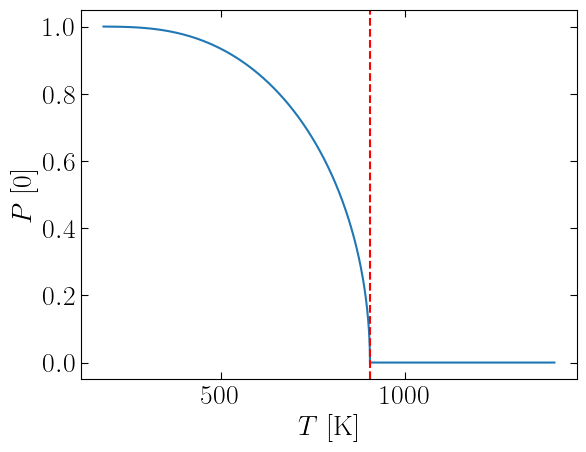

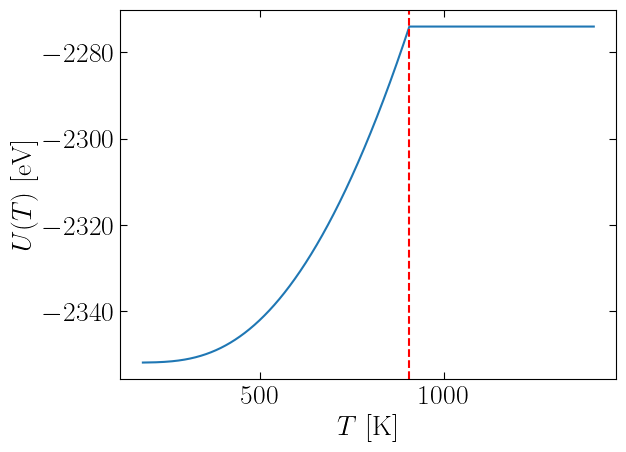

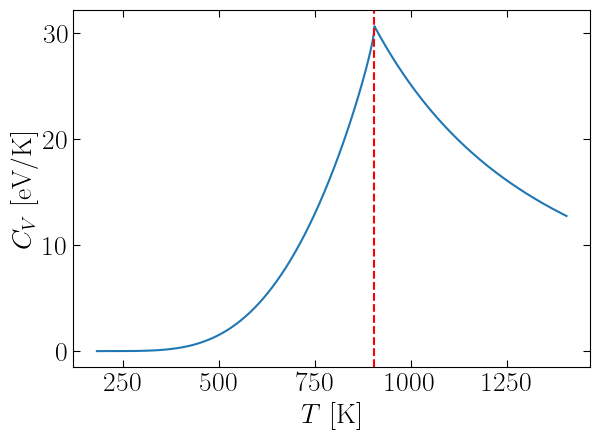

In [392]:

path = 'data/task_1/data.csv'
data = np.loadtxt(path, delimiter=',')

P = data[:, 0]
T = data[:, 1]
U = data[:, 2]/2
C = data[:, 3]



E_cucu = -0.436
E_znzn = -0.113
E_cuzn = -0.294
delta_E = E_cucu + E_znzn - 2*E_cuzn
T_c = 2*delta_E/k_B
print(f'T_c = {T_c}')

plt.figure()
plt.plot(T,abs(P))
plt.axvline(x=T_c, color='r', linestyle='--')
plt.xlabel('$T$ [K]')
plt.ylabel('$P$ [0]')
plt.savefig('figs/task_1/P_T.pdf', bbox_inches='tight')

plt.figure()
plt.plot(T,U)
plt.axvline(x=T_c, color='r', linestyle='--')
plt.xlabel('$T$ [K]')
plt.ylabel('$U(T)$ [eV]')
plt.savefig('figs/task_1/U_T.pdf', bbox_inches='tight')


plt.figure()
plt.plot(T,C)
plt.axvline(x=T_c, color='r', linestyle='--')
plt.xlabel('$T$ [K]')
plt.ylabel('$C_V$ [eV/K]')
plt.savefig('figs/task_1/C_T.pdf', bbox_inches='tight')
plt.tight_layout()

plt.show()

### Task 2 - Calculating $U$ using the Metropolis Algorithm 

In [ ]:

its_eq_400 = 200000
its_eq = 100000
its = 1000000

# data_eq_400, eq_facts_400 , _, _, _ = read_data(2, 400, its_eq=its_eq_400)
# data_eq_600, eq_facts_600 , _, _, _ = read_data(2, 600, its_eq=its_eq)
# data_eq_1000, eq_facts_1000 , _, _, _ = read_data(2, 1000, its_eq=its_eq)

# fig, axs = plt.subplots(2, 1, sharex=True)
# axs[0].plot(data_eq_400[:, 0])
# axs[1].plot(data_eq_400[:, 1])
# axs[0].set_ylabel('Accepted steps')
# axs[1].set_ylabel('Potential energy')
# axs[1].set_xlabel('MC steps')

# fig, axs = plt.subplots(2, 1, sharex=True)
# axs[0].plot(energy_data[:, 0])
# axs[1].plot(energy_data[:, 1])
# axs[0].set_ylabel('Accepted steps')
# axs[1].set_ylabel('Potential energy')
# axs[1].set_xlabel('MC steps')

# plt.tight_layout()
# plt.show()

_, _, atoms_data_400, energy_data_400, energy_facts_400 = read_data(2, 400, its_eq=its_eq_400, its=its)
_, _, atoms_data_600, energy_data_600, energy_facts_600 = read_data(2, 600, its_eq=its_eq, its=its)
_, _, atoms_data_1000, energy_data_1000, energy_facts_1000 = read_data(2, 1000, its_eq=its_eq, its=its)

accept_400_eq = energy_facts_400[1]
accept_600_eq = energy_facts_600[1]
accept_1000_eq = energy_facts_1000[1]
Epot_400 = np.mean(energy_data_400[:, 1])
Epot_600 = np.mean(energy_data_600[:, 1])
Epot_1000 = np.mean(energy_data_1000[:, 1])

df = pd.DataFrame({'T': [400, 600, 1000], 'Epot': [Epot_400, Epot_600, Epot_1000], 
                   'N_eq': [its_eq_400, its_eq, its_eq], 'Acceptance_eq': [accept_400_eq, accept_600_eq, accept_1000_eq]})
display(df)


,T,Epot,N_eq,Acceptance_eq
0,400,-583.909018,200000,0.018165
1,600,-563.172920,100000,0.101110
2,1000,-520.629598,100000,0.592380


### Task 3

#### a) Temperature dependence of $U$, $C_V$, $P$ and $r$ using MFT

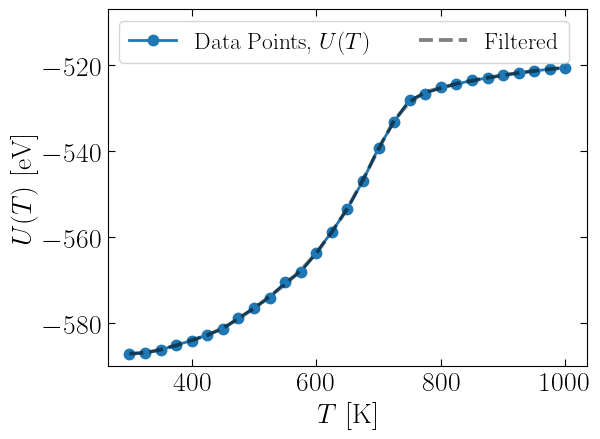

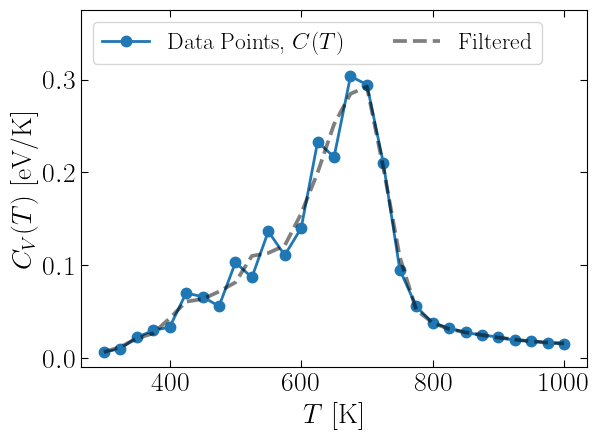

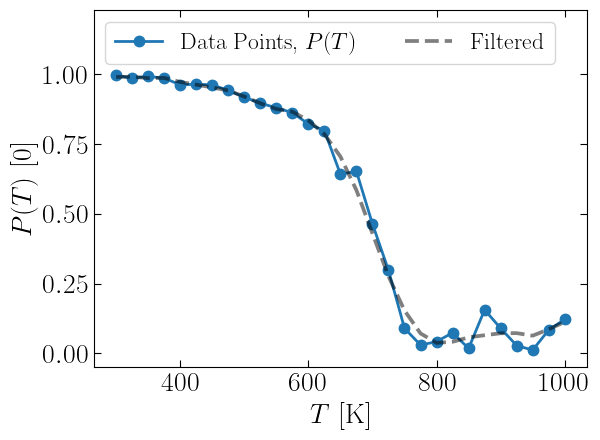

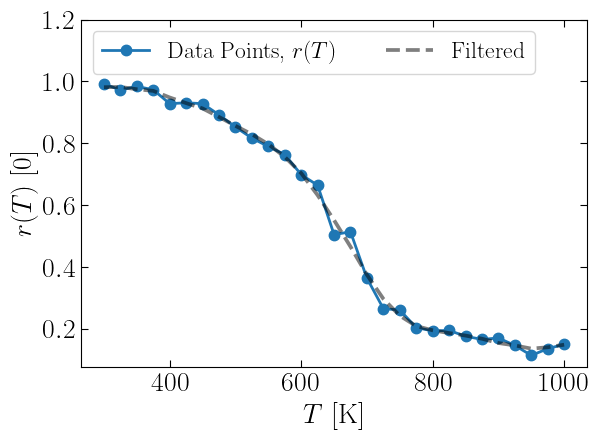

In [407]:
save = True
plot_task_3('U', save)
plot_task_3('C', save)
plot_task_3('P', save)
plot_task_3('r', save)

#### b) Error estimation using block average and autocorrelation

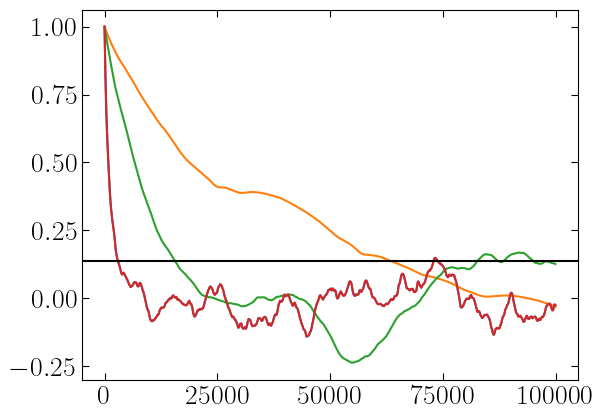

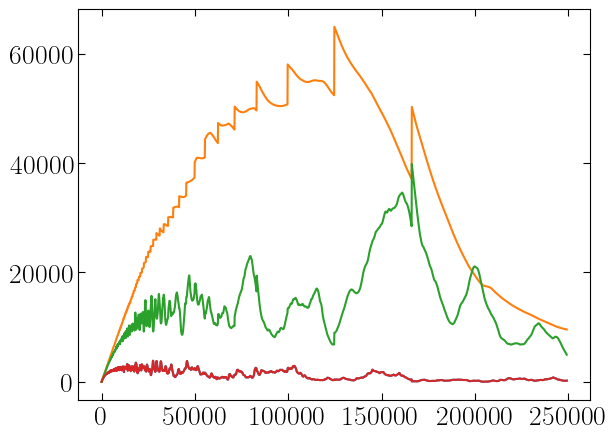

Error in U: 0.12313601528354802
Error in C_V: 0.002143117191424857
Error in P: 0.01711147131420637
Error in r: 0.001579134584546903


In [333]:

def get_data_3(task, T):
    filename_corr = f'data/task_{task}/auto_corr_{T}.csv'
    filename_block = f'data/task_{task}/blocking_{T}.csv'

    N, var_U, var_CV, var_P, var_r = np.genfromtxt(filename_corr, delimiter=',', dtype=np.float64)[1, :]
    auto_corr_data = np.genfromtxt(filename_corr, delimiter=',', dtype=np.float64)[3:, :]
    block_data = np.genfromtxt(filename_block, delimiter=',', dtype=np.float64)[1:, :]

    s_corr_U = auto_corr_data[:, 0][np.where(auto_corr_data[:, 1] < np.exp(-2))[0][0]]
    s_corr_CV = auto_corr_data[:, 0][np.where(auto_corr_data[:, 2] < np.exp(-2))[0][0]]
    s_corr_P = auto_corr_data[:, 0][np.where(auto_corr_data[:, 3] < np.exp(-2))[0][0]]
    s_corr_r = auto_corr_data[:, 0][np.where(auto_corr_data[:, 4] < np.exp(-2))[0][0]]

    error_dict = {'U': [s_corr_U, var_U], 'C_V': [s_corr_CV, var_CV], 'P': [s_corr_P, var_P], 'r': [s_corr_r, var_r]}

    return N, auto_corr_data, block_data, error_dict

N, autocorr, block, error_dict = get_data_3(3, 800)

plt.figure()
plt.plot(autocorr[:, 0], autocorr[:, 1], 'tab:blue')
plt.plot(autocorr[:, 0], autocorr[:, 2], 'tab:orange')
plt.plot(autocorr[:, 0], autocorr[:, 3], 'tab:green')
plt.plot(autocorr[:, 0], autocorr[:, 4], 'tab:red')
plt.axhline(np.exp(-2), color='k')

plt.figure()
plt.plot(block[:, 0], block[:, 1], 'tab:blue')
plt.plot(block[:, 0], block[:, 2], 'tab:orange')
plt.plot(block[:, 0], block[:, 3], 'tab:green')
plt.plot(block[:, 0], block[:, 4], 'tab:red')

plt.tight_layout()
plt.show()

s_U, var_U = error_dict['U']
s_CV, var_CV = error_dict['C_V']
s_P, var_P = error_dict['P']
s_r, var_r = error_dict['r']

error_U = np.sqrt(s_U * var_U / N)
error_CV = np.sqrt(s_CV * var_CV / N)
error_P = np.sqrt(s_P * var_P / N)
error_r = np.sqrt(s_r * var_r / N)
print(f'Error in U: {error_U}')
print(f'Error in C_V: {error_CV}')
print(f'Error in P: {error_P}')
print(f'Error in r: {error_r}')